In [1]:
import numpy as np
import wurtzite as wrtz
from openbabel import openbabel

In [2]:
lattice = wrtz.generate.create_lattice(
    dimensions=(8, 8, 1),  #  The number of cells
    cell="B4_ZnS",
)
lattice

Reading bond: 297/297

Crystal(atomic_number=array([16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16,
       30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30,
       16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16,
       30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30,
       16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16,
       30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30,
       16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16,
       30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30,
       16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16,
       30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30,
       16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16,
       30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30,
       16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16, 30, 16,
   

In [3]:
# wrtz.visualization.render(molecule=lattice, window_size=(800, 800))

Reading bond: 233/233

(<Figure size 1038.42x684.062 with 1 Axes>,
 <Axes: xlabel='OX ($\\AA$)', ylabel='OY ($\\AA$)'>)

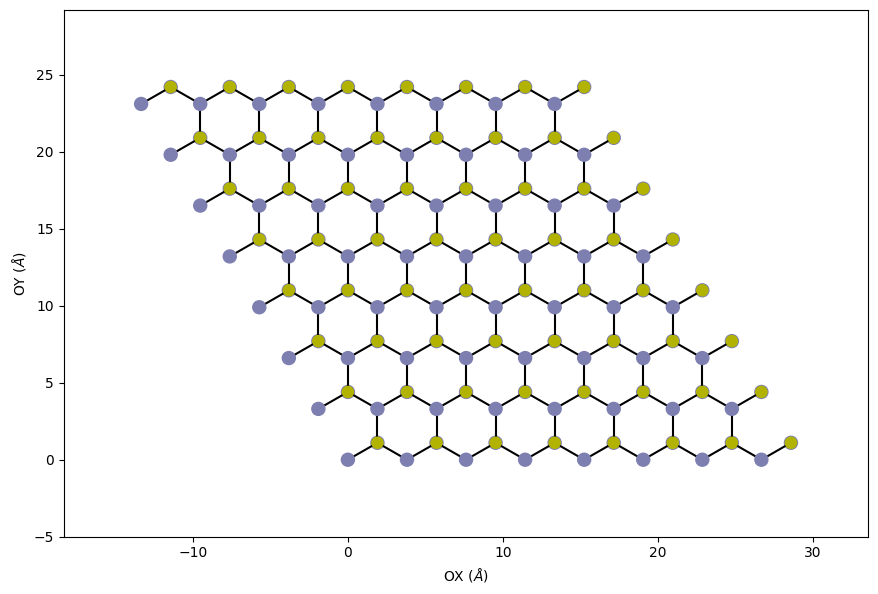

In [6]:
from openbabel import openbabel
from wurtzite.visualization import *
from wurtzite.visualization import _lighten_color
import wurtzite.generate
import dataclasses

def plot_atoms_2d(lattice, offset=5, figsize=None, xlim=None, ylim=None, xlabel=None, ylabel=None,
                  alpha: float=1.0, fig=None, ax=None, axis_font_size=14, start_z=None):
    """
    Display the lattice on the 2D plane.

    The lattice atoms are drawn on a 2D plane, in the order determined by the z coordinate, from the 
    larges z value to the smalest. In other words, atoms with the smalest z coordinate are will be in the
    forerground, all the other will be drawn in the background.

    Currently, this function does not scale atoms depending on the z coordinate -- the only factor that
    impacts the atom size is its atomic number (which determines Van Der Vals radius). 

    When the figsize is None, the size of the figure is automatically adapted to display the lattice 
    with the given `offset` value. 

    :param lattice: the lattice to display
    :param offset: the offset to apply to the figure size, relative to the ($\AA$ units). 
    :return: matplotlib figure and axis with drawn atoms 
    """
    if start_z is not None:
        new_coords = lattice.coordinates[lattice.coordinates[:, 2] > start_z]
        new_atomic_nrs = lattice.atomic_number[lattice.coordinates[:, 2] > start_z]
        lattice = dataclasses.replace(lattice, coordinates=new_coords, atomic_number=new_atomic_nrs, bonds=None)
        lattice = wurtzite.generate.update_bonds(lattice)
    
    coords = lattice.coordinates
    radiuses = [openbabel.GetVdwRad(int(nr)) for nr in lattice.atomic_number]
    colors = [get_atom_color_rgb(nr) for nr in lattice.atomic_number]
    circles = [plt.Circle((x, y), r*0.2, color=_lighten_color(c, alpha), zorder=-z) 
               for (x, y, z), r, c  in zip(coords, radiuses, colors)]
    bonds = [(coords[b[0]], coords[b[1]]) for b in lattice.bonds]
    # The offset was selected so that the bond is shown in the background of atoms.
    bond_offset = -0.5
    lines = [matplotlib.lines.Line2D((bs[0], be[0]), (bs[1], be[1]), zorder=-(bs[2]+be[2])/2+bond_offset, 
                                     color=_lighten_color("black", alpha)) 
             for bs, be in bonds if not np.allclose(bs, be)] 
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    
    for l in lines:
        ax.add_line(l)
    for c in circles:
        ax.add_patch(c)
    if xlim is None or ylim is None:
        xlim = [np.min(coords[:, 0])-offset, np.max(coords[:, 0])+offset]
        ylim = [np.min(coords[:, 1])-offset, np.max(coords[:, 1])+offset]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if figsize is None:
        # keep the correct aspect ratio
        x_min, x_max = xlim
        xw = xlim[1]-xlim[0]
        yw = ylim[1]-ylim[0]
        # 1A == 0.2 inch
        figsize = (xw*0.2, yw*0.2)
    fig.set_size_inches(*figsize)
    ax.set_xlabel("OX ($\AA$)")
    ax.set_ylabel("OY ($\AA$)")
    return fig, ax

plot_atoms_2d(lattice, start_z=2.0)